In [1]:
####################################
#LIBRARIES

import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import time
import pydde as dde
import matplotlib.pyplot as plt
import json

####################################
#Parameters
samplenum = 50
input_size = 3
output_size = 3
nTimeSteps = 10; #at 60 Hz
model_file_path = '../Trained_Models/'
data_file_path = '../Data/Samples/data_20k_2x2x2/'
simulation_file_path = "../Data/Simulations/pointmass.sim"
objective_file_path = "../Data/Objectives/pointmass.opt"

#######################################
# LOAD SIMULATION AND OBJECTIVE FUNCTION
dyn = dde.DynamicSequence()
print('hello')
dyn.loadFile(simulation_file_path, nTimeSteps)
p_init = np.zeros(dyn.p0.size*nTimeSteps)
for i in range(0,nTimeSteps):
	p_init[i*dyn.p0.size : (i+1)*dyn.p0.size] = dyn.p0

#############################################
#LOAD OBJECTIVE PYDDE_V2
obj = dde.InverseObjective(dyn)
obj.loadFile(objective_file_path)
objective_json = json.load(open(objective_file_path))

#############################################
#GENERATE OPTIMIZATION PYDDE_V2
opt = dde.Newton()

#Sample targets only variables in z direction
y_target = np.zeros((samplenum, 3))
y_target[:,2] = np.random.rand(samplenum)
y_target[:,1] = 2
print('cool2')

###################################
#USE P FROM TRAJ_OPT
p = np.ones((3*nTimeSteps, samplenum))
for i in range(samplenum):
    objective_json["objectives"]["pmTargetPositions"][0]["targetPos"] = ([[y_target[i,0]],[y_target[i,1]],[y_target[i,2]]]) 
    obj.loadJson(objective_json)
    p[:,i] = opt.minimize(obj, p_init)
p = torch.tensor(p, requires_grad = True).t()
print(p)

In [5]:
import sys
print(sys.path)

['/private/var/folders/fg/z9hxlwkx7dl424b9sm5btqmh0000gn/T/cbe117fc-46b2-4cfe-b7bd-e90c47981a88', '/Users/nicovonau/.vscode/extensions/ms-python.python-2020.6.91350/pythonFiles', '/Users/nicovonau/.vscode/extensions/ms-python.python-2020.6.91350/pythonFiles/lib/python', '/Users/nicovonau/anaconda3/lib/python37.zip', '/Users/nicovonau/anaconda3/lib/python3.7', '/Users/nicovonau/anaconda3/lib/python3.7/lib-dynload', '', '/Users/nicovonau/anaconda3/lib/python3.7/site-packages', '/Users/nicovonau/anaconda3/lib/python3.7/site-packages/aeosa', '/Users/nicovonau/pathpy', '/Users/nicovonau/anaconda3/lib/python3.7/site-packages/IPython/extensions', '/Users/nicovonau/.ipython']


In [102]:
##############################
#USE P_INIT ONLY
p = np.ones((3*nTimeSteps, samplenum))
for i in range(samplenum):
    p[:,i] = dyn.p_init
p = torch.tensor(p, requires_grad = True).t()
input = p.double()
print(p)
print(p.shape)

tensor([[0., 3., 0., 0., 3., 0., 0., 3., 0.],
        [0., 3., 0., 0., 3., 0., 0., 3., 0.],
        [0., 3., 0., 0., 3., 0., 0., 3., 0.],
        [0., 3., 0., 0., 3., 0., 0., 3., 0.],
        [0., 3., 0., 0., 3., 0., 0., 3., 0.]], dtype=torch.float64,
       grad_fn=<TBackward>)
torch.Size([5, 9])


In [149]:
################################
#BUILD CUSTOM FUNCTION

class Simulate(torch.autograd.Function):
    
    @staticmethod
    def forward(ctx, input):
        #print(f'input: {input.shape}')
        p = input.clone().numpy().transpose()
        y_pred = torch.ones([len(p[0, :]),3])
        for i in range(len(p[0, :])):
            state = dyn.compute(p[:,i])
            y_pred[i, :] = torch.tensor(state.y[-3:])
        #print(f'y_pred: {y_pred.shape}')
        
        ctx.save_for_backward(input)
        
        return y_pred
        
    @staticmethod
    def backward(ctx, grad_output):
        #print(grad_output)
        input, = ctx.saved_tensors
        p = input.clone().numpy().transpose()
        dy_dp_batch = torch.zeros([3, 3*nTimeSteps])
        for i in range(len(p[0, :])):
            state= dyn.compute(p[:, i])
            dy_dp = dyn.dy_dp(state, p[:, i])
            dy_dp = torch.tensor(dy_dp[-3:, :])
            dy_dp_batch = dy_dp_batch + dy_dp
        #print(f'dy/dp_batch: {dy_dp_batch/samplenum}')
        
        grad_input = torch.tensor(grad_output.double().mm(dy_dp_batch/samplenum))
        #print(f'shape of grad input: {grad_input.shape}')
        #print(f'shape of grad output: {grad_output.shape}')
        return grad_input

Simulate = Simulate.apply

In [150]:
################################
#GET ANALYTICAL GRADIENT

# Error for whole simulation
from numpy import linalg as LA

p = torch.tensor(p, requires_grad = True).double()
y = Simulate(p)
grad_output = torch.ones([samplenum,3]).double()
y.backward(grad_output)
dy_dp = p.grad.double()
print(f'dy_dp shape = {dy_dp.shape}')
print(f'dy_dp = {dy_dp}')

dy_dp shape = torch.Size([500, 9])
dy_dp = tensor([[-0.0021, -0.0967, -0.0010,  ...,  0.0157,  0.9260,  0.0498],
        [-0.0021, -0.0967, -0.0010,  ...,  0.0157,  0.9260,  0.0498],
        [-0.0021, -0.0967, -0.0010,  ...,  0.0157,  0.9260,  0.0498],
        ...,
        [-0.0021, -0.0967, -0.0010,  ...,  0.0157,  0.9260,  0.0498],
        [-0.0021, -0.0967, -0.0010,  ...,  0.0157,  0.9260,  0.0498],
        [-0.0021, -0.0967, -0.0010,  ...,  0.0157,  0.9260,  0.0498]],
       dtype=torch.float64)


In [151]:
################################
#GET NUMERICAL GRADIENT WITH DIFFERENT PERTUBATIONS

dy_dp_s = np.zeros((3,len(dyn.p_init)))
#dy_dp_FD = np.zeros((3,len(dyn.p_init)))
#FD = [1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
FD = np.logspace(np.log10(0.000001),np.log10(0.01),num = 100)
Grads = {}
Err = []
analytical_grad = dy_dp.detach().numpy()

for f, fd in enumerate(FD):
    dy_dp_FD = np.zeros((3,len(dyn.p_init)))
    for s in range(samplenum):
        for i in range(len(dyn.p_init)):
            dp= np.zeros(len(dyn.p_init))
            dp[i] = fd
            dp = torch.tensor(dp)
            p_s = p[s,:]
            p_s = p_s.unsqueeze(0)
            y_p = Simulate(p_s + dp)
            y_m = Simulate(p_s - dp)
            y_p = y_p.detach().numpy()
            y_m = y_m.detach().numpy()
            grad_i = (y_p - y_m) / (2 * fd)
            dy_dp_s[:, i]= grad_i
        dy_dp_FD = dy_dp_FD + dy_dp_s
    dy_dp_FD_ten = torch.tensor(dy_dp_FD)
    Grads[fd] = torch.tensor(grad_output.double().mm(dy_dp_FD_ten/samplenum))
    #print(f' dy_dp_FD at eps {fd} = \n{dy_dp_FD}')
    Err.append(LA.norm(Grads[fd] - analytical_grad))
#print(Err)

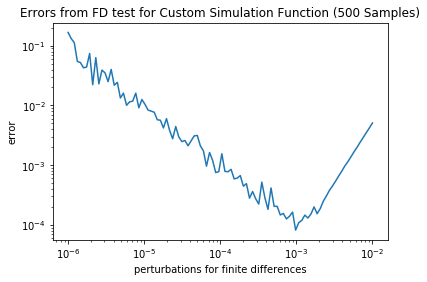

In [152]:
################################
#PLOT ERRORS OVER DIFFERENT PERTURBATIONS

plt.plot(FD, Err)
plt.xscale('log')
plt.yscale('log')
plt.ylabel('error')
plt.xlabel('perturbations for finite differences')
plt.title('Errors from FD test for Custom Simulation Function (500 Samples)')
plt.show()

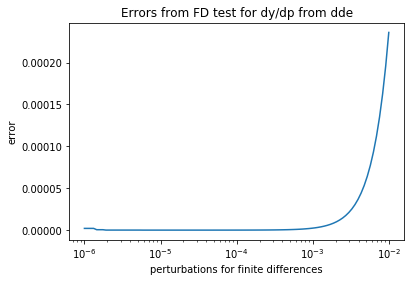

In [134]:
################################
#FD TEST FOR DY/DP FUNCTION

from numpy import linalg as LA
#FD = [1e-2, 1e-3, 1e-4, 1e-5]
#FD = np.linspace(0.000001,0.01, num = 100)
FD = np.logspace(np.log10(0.000001),np.log10(0.01),num = 100)
FDs = []

#Calculate dy_dp with FE
dy_dp = dyn.dy_dp(state_init, dyn.p_init)[-3:, :]
dy_dp_FD = np.zeros((3,len(dyn.p_init)))

for i, fd in enumerate(FD):
    for i in range(len(dyn.p_init)):
        dp= np.zeros(len(dyn.p_init))
        dp[i] = fd
        y_p = dyn.compute(dyn.p_init + dp)
        y_m = dyn.compute(dyn.p_init - dp)
        dy_dp_FD[:, i] = (y_p.y[-3:] - y_m.y[-3:]) / (2* fd)
    err = LA.norm(dy_dp_FD - dy_dp)
    #print(err)
    FDs.append(err)

plt.plot(FD, FDs)
plt.xscale('log')
plt.ylabel('error')
plt.title('Errors from FD test for dy/dp from dde')
plt.xlabel('perturbations for finite differences')
plt.show()